[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Estimate Vehicle Speed with Computer Vision

---

[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/uWP6UjDeZvY)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/supervision/tree/develop/examples/speed_estimation)

## Accompanying Materials

We recommend that you follow along in this notebook while watching the YouTube [tutorial](https://youtu.be/uWP6UjDeZvY) on how to estimate vehicle speed with computer vision. You can also find the code below in Python script form as one of the [supervision/examples](https://github.com/roboflow/supervision/tree/develop/examples).

[![YouTube Video](https://github.com/SkalskiP/SkalskiP/assets/26109316/61a444c8-b135-48ce-b979-2a5ab47c5a91)](https://youtu.be/uWP6UjDeZvY)

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install
- Imports
- Download Data
- Configuration
- Source and Target ROIs
- Transform Perspective
- Process Video

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Mar 19 09:27:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install

In [2]:
!pip install -q supervision "ultralytics<=8.3.40"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.0 MB/s eta 0:00:00


## Imports

In [3]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Download Data

**NOTE:** In this notebook we will use one of the Supervision Assets videos. [Here](https://supervision.roboflow.com/assets) you can learn more about it.

In [4]:
download_assets(VideoAssets.VEHICLES)

  0%|          | 0/35345757 [00:00<?, ?it/s]

'vehicles.mp4'

## Configuration

In [73]:
!pip install gdown
import gdown

SOURCE_VIDEO_PATH = "myvideo.mp4"
google_drive_file_id = "1TkeC9vMvz3WzfEmnUh89kse0EqedcCot"
google_drive_file_url = f"https://drive.google.com/uc?id={google_drive_file_id}"
gdown.download(google_drive_file_url, SOURCE_VIDEO_PATH, quiet=False)

TARGET_VIDEO_PATH = "result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

Downloading...
From (original): https://drive.google.com/uc?id=1TkeC9vMvz3WzfEmnUh89kse0EqedcCot
From (redirected): https://drive.google.com/uc?id=1TkeC9vMvz3WzfEmnUh89kse0EqedcCot&confirm=t&uuid=efc58175-db1f-4dac-a050-52e99b8776f9
To: /content/myvideo.mp4
100%|██████████| 213M/213M [00:01<00:00, 145MB/s]


## Source and Target ROIs

![Source and Target ROIs](https://storage.googleapis.com/com-roboflow-marketing/notebooks/speed-estimation-perspective-1.png)

In [74]:
import numpy as np

SOURCE = np.array([
    [900, 200],
    [1300, 200],
    [1900, 1000],
    [800, 1000]
])

TARGET_WIDTH = 25   # Adjust based on your real-world measurement
TARGET_HEIGHT = 300 # Adjust based on your real-world measurement

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH, 0],
    [TARGET_WIDTH, TARGET_HEIGHT],
    [0, TARGET_HEIGHT],
])
H, _ = cv2.findHomography(SOURCE, TARGET)

In [75]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

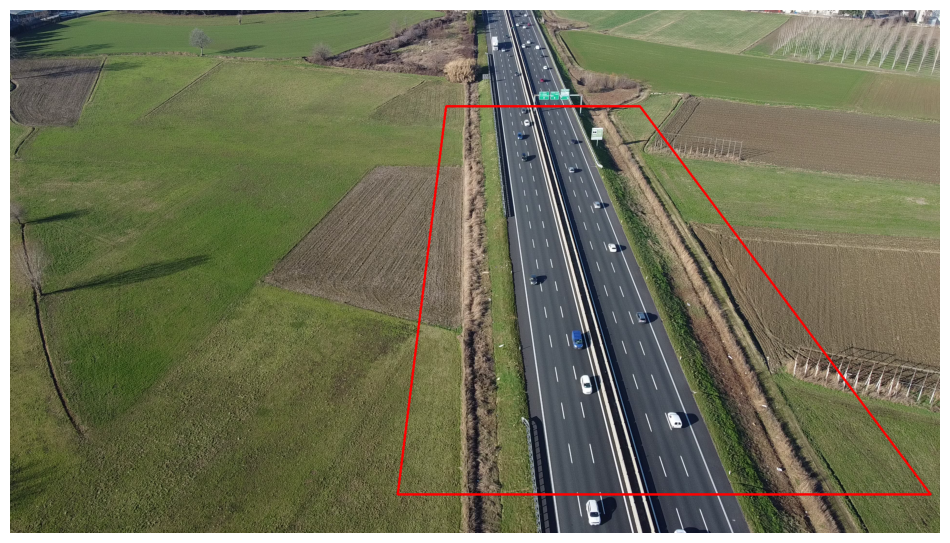

In [76]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.RED, thickness=4)
sv.plot_image(annotated_frame)

In [77]:
def transform_points(points: np.ndarray, homography: np.ndarray) -> np.ndarray:
    if len(points) == 0:
        return points
    pts_reshaped = points.reshape(-1, 1, 2).astype(np.float32)
    transformed = cv2.perspectiveTransform(pts_reshaped, homography)
    return transformed.reshape(-1, 2)


## Transform Perspective

In [78]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

# 1) Create the transformer
transformer = ViewTransformer(source=SOURCE, target=TARGET)

# 2) For each frame, after you get detection points in the original image:
points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

# 3) Transform to real-world plane
transformed_points = transformer.transform_points(points)

# 4) Store these real-world coords in 'coordinates' dict for speed calc
for tracker_id, (tx, ty) in zip(detections.tracker_id, transformed_points):
    coordinates[tracker_id].append((tx, ty))

# 5) When you have enough points, compute speed using 2D distance in 'transformed_points'


In [79]:
!pip install --upgrade supervision
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

## Process Video

In [80]:
pip install --upgrade supervision

**NOTE:** In this tutorial we use Supervision Annotators. [Here](https://supervision.roboflow.com/annotators) you can learn more about it.

In [81]:
def main():
    # Initialize YOLO model
    model = YOLO(MODEL_NAME)

    # Load video info and create a frame generator
    video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
    frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

    # Create ByteTrack (or other) tracker
    byte_track = sv.ByteTrack(
        frame_rate=video_info.fps,
        track_activation_threshold=CONFIDENCE_THRESHOLD
    )

    # Prepare annotators (optional styling)
    thickness = sv.calculate_optimal_line_thickness(video_info.resolution_wh)
    text_scale = sv.calculate_optimal_text_scale(video_info.resolution_wh)
    bounding_box_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_scale=text_scale, text_thickness=thickness, text_position=sv.Position.BOTTOM_CENTER
    )
    trace_annotator = sv.TraceAnnotator(
        thickness=thickness, trace_length=int(video_info.fps * 2),  # e.g., 2 seconds of trace
        position=sv.Position.BOTTOM_CENTER
    )

    # (Optional) define a polygon zone if you want to filter by region of interest
    # polygon_zone = sv.PolygonZone(polygon=SOURCE)  # But note, this polygon is just for detection filtering.

    # Dictionary to store real-world coordinates for each tracker_id over time
    # Using a deque so we only keep the last 'N' frames for each ID
    coordinates = defaultdict(lambda: deque(maxlen=int(video_info.fps * 2)))  # store up to 2 seconds of data

    # Open the output video
    with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
        for frame in frame_generator:
            # 3.1) Run YOLO detection
            result = model(frame, imgsz=1280, verbose=False)[0]
            detections = sv.Detections.from_ultralytics(result)

            # 3.2) Filter out detections by confidence or class if needed
            detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
            # e.g., remove person class if it's class 0
            # detections = detections[detections.class_id != 0]

            # 3.3) (Optional) filter by polygon zone
            # detections = detections[polygon_zone.trigger(detections)]

            # 3.4) Apply NMS
            detections = detections.with_nms(IOU_THRESHOLD)

            # 3.5) Pass detections to the tracker
            detections = byte_track.update_with_detections(detections=detections)

            # 3.6) Extract anchor points (e.g., bottom-center of each bounding box)
            image_points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
            # shape is Nx2 (x, y)

            # 3.7) Transform anchor points to real-world coords
            real_world_points = transform_points(image_points, H)

            # 3.8) Store real-world coords in 'coordinates'
            for tracker_id, (rx, ry) in zip(detections.tracker_id, real_world_points):
                coordinates[tracker_id].append((rx, ry))

            # 3.9) Compute speed for each tracker
            labels = []
            for tracker_id in detections.tracker_id:
                pts = coordinates[tracker_id]
                # Only compute speed if we have enough frames
                if len(pts) > int(video_info.fps * 0.5):  # e.g., 0.5 seconds of data
                    (rx1, ry1) = pts[-1]  # most recent
                    (rx0, ry0) = pts[0]   # oldest
                    dist_m = np.sqrt((rx1 - rx0)**2 + (ry1 - ry0)**2)
                    time_s = len(pts) / video_info.fps
                    speed_m_s = dist_m / time_s
                    speed_km_h = speed_m_s * 3.6
                    labels.append(f"#{tracker_id} {int(speed_km_h)} km/h")
                else:
                    labels.append(f"#{tracker_id}")

            # 3.10) Annotate frame with bounding boxes, traces, labels
            annotated_frame = frame.copy()
            annotated_frame = trace_annotator.annotate(
                scene=annotated_frame, detections=detections
            )
            annotated_frame = bounding_box_annotator.annotate(
                scene=annotated_frame, detections=detections
            )
            annotated_frame = label_annotator.annotate(
                scene=annotated_frame, detections=detections, labels=labels
            )

            # 3.11) Write annotated frame to output
            sink.write_frame(annotated_frame)

    print("Processing complete. Results saved to:", TARGET_VIDEO_PATH)

if __name__ == "__main__":
    main()


Processing complete. Results saved to: result.mp4


In [82]:
from google.colab import files

files.download('result.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.